# Practical

In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

# Fine Tuning

In [2]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [3]:
num_classes = 10
batch_size = 8
num_epochs = 5

model_ft = models.alexnet(pretrained=True)

num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
input_size = 224

print(model_ft)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [4]:
transforms_train = transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

transforms_val = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

batch_size = 64

train_data = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transforms_train)

train_size = int(len(train_data) * 0.8)
valid_size = len(train_data) - train_size

train_data, val_data = torch.utils.data.random_split(train_data, [train_size, valid_size])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,shuffle=True, num_workers=2)

test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_train)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

dataloaders_dict = {
    'train': train_loader,
    'val': val_loader
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified
Files already downloaded and verified


In [5]:
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.3.weight
	 features.3.bias
	 features.6.weight
	 features.6.bias
	 features.8.weight
	 features.8.bias
	 features.10.weight
	 features.10.bias
	 classifier.1.weight
	 classifier.1.bias
	 classifier.4.weight
	 classifier.4.bias
	 classifier.6.weight
	 classifier.6.bias


In [6]:
criterion = nn.CrossEntropyLoss()

model_ft, hist = train_model(model_ft,
                             dataloaders_dict,
                             criterion,
                             optimizer_ft,
                             num_epochs=num_epochs)

Epoch 0/4
----------
train Loss: 1.1173 Acc: 0.6007
val Loss: 0.9035 Acc: 0.6783

Epoch 1/4
----------
train Loss: 0.8917 Acc: 0.6862
val Loss: 0.8321 Acc: 0.7006

Epoch 2/4
----------
train Loss: 0.8317 Acc: 0.7064
val Loss: 0.7812 Acc: 0.7240

Epoch 3/4
----------
train Loss: 0.7860 Acc: 0.7230
val Loss: 0.7448 Acc: 0.7312

Epoch 4/4
----------
train Loss: 0.7617 Acc: 0.7299
val Loss: 0.7011 Acc: 0.7533

Training complete in 111m 17s
Best val Acc: 0.753300


In [7]:
torch.save(model_ft.state_dict(), './alexnet_finetuned_2.pth')

In [8]:
model_ft = models.alexnet(pretrained=True)
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
input_size = 224

model_ft.load_state_dict(torch.load('./alexnet_finetuned_2.pth'))

<All keys matched successfully>

In [10]:
correct, total = 0, 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy on test set: {100 * correct // total} %')

Accuracy on test set: 72 %


# Feature Extraction

In [11]:
num_classes = 10
batch_size = 8
num_epochs = 5

In [12]:
model_fe = models.alexnet(pretrained=True)

for param in model_fe.parameters():
            param.requires_grad = False

num_ftrs = model_fe.classifier[6].in_features
model_fe.classifier[6] = nn.Linear(num_ftrs,num_classes)
input_size = 224

model_fe = model_fe.to(device)

params_to_update = model_fe.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_fe.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_fe.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer_fe = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [13]:
model_fe, hist = train_model(model_fe,
                             dataloaders_dict,
                             criterion,
                             optimizer_fe,
                             num_epochs=num_epochs)


Epoch 0/4
----------
train Loss: 1.2580 Acc: 0.5513
val Loss: 1.0934 Acc: 0.6117

Epoch 1/4
----------
train Loss: 1.1300 Acc: 0.5985
val Loss: 1.0385 Acc: 0.6271

Epoch 2/4
----------
train Loss: 1.1089 Acc: 0.6029
val Loss: 1.0090 Acc: 0.6426

Epoch 3/4
----------
train Loss: 1.0817 Acc: 0.6143
val Loss: 0.9846 Acc: 0.6494

Epoch 4/4
----------
train Loss: 1.0812 Acc: 0.6124
val Loss: 0.9675 Acc: 0.6580

Training complete in 46m 54s
Best val Acc: 0.658000


In [14]:
torch.save(model_fe.state_dict(), './alexnet_featureextract_2.pth')

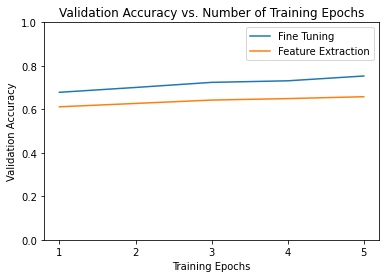

In [17]:
fhist = []

fhist = [h.cpu().numpy() for h in hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Fine Tuning")
plt.plot(range(1,num_epochs+1),fhist,label="Feature Extraction")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [16]:
correct, total = 0, 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model_fe(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy on test set: {100 * correct // total} %')

Accuracy on test set: 65 %
